# Food Vision Project

Welcome to the Food Vision project! In this deep-learning project, we will explore the fascinating field of image classification and create a powerful model capable of predicting the type of food present in images. The goal is to accurately classify images into one of 101 different food classes.

We'll leverage the power of deep learning and Convolutional Neural Networks (CNNs) to build an image classifier. We'll use a popular deep-learning library such as TensorFlow to develop and train our model.

The dataset for this project consists of a diverse collection of food images from 101 different food categories. Each image is labeled with its corresponding class, making it a supervised learning problem.

In [5]:
# Import necessary libraries
import os
import datetime
import random
import zipfile
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import tensorflow as tf
from tensorflow.keras import mixed_precision
from tensorflow.keras.layers.experimental import preprocessing
import tensorflow_datasets as tfds
import warnings
import itertools

warnings.filterwarnings('ignore')

print(tf.__version__)

2.13.0


## Download Food101 datasets from tensorflow datasets

Food101: This dataset consists of 101 food categories, with 101,000 images. For each class, 250 manually reviewed test images are provided as well as 750 training images. On purpose, the training images were not cleaned, and thus still contain some amount of noise. This comes mostly in the form of intense colors and sometimes wrong labels. All images were rescaled to have a maximum side length of 512 pixels

In [6]:
# Load the data from tensorlow datasets
(train_data, test_data), ds_info = tfds.load(name='food101',
                                   split=['train', 'validation'],
                                   shuffle_files=True,
                                   as_supervised=True,
                                   with_info=True)

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Shuffling /root/tensorflow_datasets/food101/2.0.0.incompleteCZUTUM/food101-train.tfrecord*...:   0%|          …

Generating validation examples...:   0%|          | 0/25250 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/food101/2.0.0.incompleteCZUTUM/food101-validation.tfrecord*...:   0%|     …

Dataset food101 downloaded and prepared to /root/tensorflow_datasets/food101/2.0.0. Subsequent calls will reuse this data.


## Exploring Food101 dataset

In [7]:
 # Check out the info
ds_info

tfds.core.DatasetInfo(
    name='food101',
    full_name='food101/2.0.0',
    description="""
    This dataset consists of 101 food categories, with 101'000 images. For each class, 250 manually reviewed test images are provided as well as 750 training images. On purpose, the training images were not cleaned, and thus still contain some amount of noise. This comes mostly in the form of intense colors and sometimes wrong labels. All images were rescaled to have a maximum side length of 512 pixels.
    """,
    homepage='https://data.vision.ee.ethz.ch/cvl/datasets_extra/food-101/',
    data_path=PosixGPath('/tmp/tmpzzc57k7qtfds'),
    file_format=tfrecord,
    download_size=4.65 GiB,
    dataset_size=4.77 GiB,
    features=FeaturesDict({
        'image': Image(shape=(None, None, 3), dtype=uint8),
        'label': ClassLabel(shape=(), dtype=int64, num_classes=101),
    }),
    supervised_keys=('image', 'label'),
    disable_shuffling=False,
    splits={
        'train': <SplitInfo num_exam

In [8]:
# Check the info features
ds_info.features

FeaturesDict({
    'image': Image(shape=(None, None, 3), dtype=uint8),
    'label': ClassLabel(shape=(), dtype=int64, num_classes=101),
})

In [9]:
# Get the class names
class_names = ds_info.features['label'].names

# Check the first 10 classes
class_names[:10]

['apple_pie',
 'baby_back_ribs',
 'baklava',
 'beef_carpaccio',
 'beef_tartare',
 'beet_salad',
 'beignets',
 'bibimbap',
 'bread_pudding',
 'breakfast_burrito']

In [10]:
ds_info.features['image']

Image(shape=(None, None, 3), dtype=uint8)

In [11]:
# Get the one sample from training data
train_one_sample = train_data.take(1)
train_one_sample

<_TakeDataset element_spec=(TensorSpec(shape=(None, None, 3), dtype=tf.uint8, name=None), TensorSpec(shape=(), dtype=tf.int64, name=None))>

In [12]:
# Check out the shape of
for image, label in train_one_sample:
    print(f'''Image Shape: {image.shape}
Image Datatype: {image.dtype}
Image class: {class_names[label]}''')

Image Shape: (341, 512, 3)
Image Datatype: <dtype: 'uint8'>
Image class: tiramisu


In [13]:
# How does look like a image
image

<tf.Tensor: shape=(341, 512, 3), dtype=uint8, numpy=
array([[[  2,   2,   0],
        [  2,   2,   0],
        [  2,   2,   0],
        ...,
        [  0,   3,   0],
        [  0,   4,   0],
        [  0,   4,   0]],

       [[  2,   2,   0],
        [  2,   2,   0],
        [  3,   3,   1],
        ...,
        [  1,   3,   0],
        [  0,   4,   0],
        [  0,   4,   0]],

       [[  5,   6,   1],
        [  5,   6,   1],
        [  5,   6,   1],
        ...,
        [  1,   3,   0],
        [  0,   4,   0],
        [  0,   5,   1]],

       ...,

       [[143,  75,  10],
        [149,  81,  16],
        [150,  85,  19],
        ...,
        [162,  88,  25],
        [150,  79,  17],
        [135,  65,   5]],

       [[144,  76,  11],
        [152,  84,  19],
        [145,  80,  16],
        ...,
        [126,  60,  12],
        [111,  50,   3],
        [ 95,  37,   0]],

       [[145,  77,  14],
        [150,  82,  19],
        [139,  74,  10],
        ...,
        [ 89,  35,   

In [14]:
# Get the max and min value of image
tf.reduce_max(image).numpy(), tf.reduce_min(image).numpy()

(255, 0)

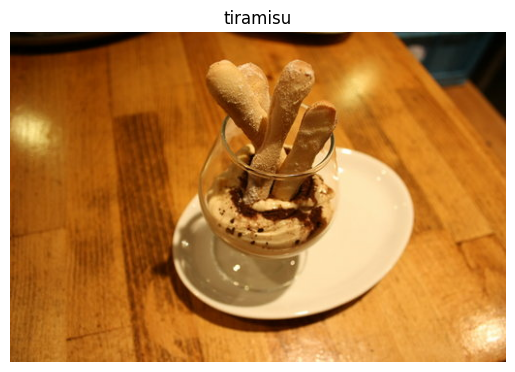

In [15]:
# Plot the image
plt.imshow(image)
plt.title(class_names[label])
plt.axis(False);

## Create a function for data preprocessing

Neural networks performs better when the data in a certain way such as batched, normalized, etc. But when you loaded your data from tensorflow datasets, it doesn't come like this. So you have to write some function and map it in your data to ready your data. In this case our data:
* has different sized images
* dtype `unit8`
* not scaled (values between 0 and 255)

What should we do:
* change the dtype such as `float32` or mixed precision (`float32` and `float16`)
* turn the all images in same size
* scale images (change the tensor values between 0 and 1) (Actually we dont have to scale our data because efficientnet already has scaled layer in it)



In [16]:
# Make a function for data proprocessing
def image_preprocessing(image, label, image_shape=224):
    """
    Converts image datatype float32 and reshapes image to [image_shape, image_shape, channel]
    """
    image = tf.image.resize(image, [image_shape, image_shape]) # reshape the image
    # image = image/255. # We dont need that because EfficientNetBX has built in
    return tf.cast(image, tf.float32), label # return the image and label together

In [17]:
# Check out the function
preprocessed_image = image_preprocessing(image, label)[0]
print(f'Before the preprocessing:\nShape: {image.shape}\nDtype: {image.dtype}\nImage: {image[:2]}')
print('\n')
print(f'After the preprocessing:\nShape: {preprocessed_image.shape}\nDtype: {preprocessed_image.dtype}\nImage: {preprocessed_image[:2]}')

Before the preprocessing:
Shape: (341, 512, 3)
Dtype: <dtype: 'uint8'>
Image: [[[2 2 0]
  [2 2 0]
  [2 2 0]
  ...
  [0 3 0]
  [0 4 0]
  [0 4 0]]

 [[2 2 0]
  [2 2 0]
  [3 3 1]
  ...
  [1 3 0]
  [0 4 0]
  [0 4 0]]]


After the preprocessing:
Shape: (224, 224, 3)
Dtype: <dtype: 'float32'>
Image: [[[2.         2.         0.        ]
  [2.947226   2.947226   0.947226  ]
  [4.         5.         0.        ]
  ...
  [1.         3.         0.        ]
  [0.01865775 2.757497   0.        ]
  [0.         4.         0.        ]]

 [[4.350446   5.1339283  0.7834821 ]
  [4.566964   5.350446   1.        ]
  [4.783482   5.783482   0.7834821 ]
  ...
  [1.         3.         0.        ]
  [0.7989505  2.7989504  0.        ]
  [0.         4.2798424  0.27984235]]]


## Batch and Prepare Dataset

https://www.tensorflow.org/guide/data_performance

In [18]:
# Map preprocessing function to training data (and paralelize)
train_data = train_data.map(map_func=image_preprocessing, num_parallel_calls=tf.data.AUTOTUNE)

# Shuffle the data and turn into batches and prefetch it
train_data = train_data.shuffle(buffer_size=1000).batch(batch_size=32).prefetch(buffer_size=tf.data.AUTOTUNE)

# Map proprocessing function to test data
test_data = test_data.map(map_func=image_preprocessing, num_parallel_calls=tf.data.AUTOTUNE).batch(batch_size=32).prefetch(buffer_size=tf.data.AUTOTUNE)

In [19]:
# Check out the train and test data
train_data, test_data

(<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>,
 <_PrefetchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>)

## Creating modelling callbakcs

I will create two different callbacks:

* ModelCheckpoint: to save our model's progress after feature extraction
* TensorBoard: to log training results

In [20]:
# Create tensorboard callback from helper_function.py
from helper_functions import create_tensorboard_callback

In [21]:
# Create ModelCheckpoint callback
model_checkpoint_dir = 'checkpoint/cp.cpkt'
model_checkpoint = tf.keras.callbacks.ModelCheckpoint(filepath=model_checkpoint_dir,
                                                      save_best_only=True,
                                                      save_weights_only=True,
                                                      save_preq='epoch',
                                                      monitor='val_accuracy',
                                                      verbose=0)

## Setup mixed precision training

TensorFlow's mixed precision is a feature that allows you to perform computations using a combination of different numerical precisions, typically 32-bit and 16-bit, within a single neural network model. This feature leverages the benefits of both precision types to optimize training performance while maintaining model accuracy.


The benefits of using mixed precision include:

* Faster Training: Utilizing float16 operations reduces computation time, leading to faster training cycles.
* Lower Memory Usage: The reduced memory footprint of float16 helps in training larger models or handling larger batch sizes, which can further improve training speed.
* Enhanced Hardware Utilization: Some hardware accelerators, such as NVIDIA Tensor Cores, are specifically designed to perform faster computations with float16 inputs.
* Maintained Accuracy: Despite using lower precision during computations, the model's overall accuracy can often be preserved by careful tuning and appropriate scaling techniques.

https://www.tensorflow.org/guide/mixed_precision

In [22]:
# Set global policy to mixed precision
mixed_precision.set_global_policy('mixed_float16')

In [23]:
# Check out the global policy
policy = mixed_precision.Policy('mixed_float16')
print('Compute dtype: %s' % policy.compute_dtype)
print('Variable dtype: %s' % policy.variable_dtype)

Compute dtype: float16
Variable dtype: float32


## Creating a feature extraction model

In [24]:
# Setup input shape
IMAGE_SHAPE=(224, 224, 3)

# Create a base model
base_model = tf.keras.applications.EfficientNetB0(include_top=False)
base_model.trainable = False

# Create a functional model
inputs = tf.keras.Input(shape=IMAGE_SHAPE, name='input_layer')
# x = preprocessing.Rescaling(1/255.)(inputs) #EfficientNetB0 doesn't require that because built in layer
x = base_model(inputs, training=False)
x = tf.keras.layers.GlobalAveragePooling2D()(x)
outputs = tf.keras.layers.Dense(len(class_names), activation='softmax', dtype=tf.float32)(x)
model = tf.keras.Model(inputs, outputs)

# Compile the model
model.compile(
    loss='sparse_categorical_crossentropy',
    optimizer=tf.keras.optimizers.Adam(),
    metrics=['accuracy']
)

16705208/16705208 [==============================] - 0s 0us/step


In [25]:
# Check the model summary
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 efficientnetb0 (Functional  (None, None, None, 1280   4049571   
 )                           )                                   
                                                                 
 global_average_pooling2d (  (None, 1280)              0         
 GlobalAveragePooling2D)                                         
                                                                 
 dense (Dense)               (None, 101)               129381    
                                                                 
Total params: 4178952 (15.94 MB)
Trainable params: 129381 (505.39 KB)
Non-trainable params: 4049571 (15.45 MB)
_________________________________________________________________


## Check the model layer's dtype policies

In [26]:
# Check the layers policies
for layer in model.layers:
    print(f'Layer name: {layer.name} -- Trainable: {layer.trainable} -- Dtype: {layer.dtype} -- Dtype policy: {layer.dtype_policy}')

Layer name: input_layer -- Trainable: True -- Dtype: float32 -- Dtype policy: <Policy "float32">
Layer name: efficientnetb0 -- Trainable: False -- Dtype: float32 -- Dtype policy: <Policy "mixed_float16">
Layer name: global_average_pooling2d -- Trainable: True -- Dtype: float32 -- Dtype policy: <Policy "mixed_float16">
Layer name: dense -- Trainable: True -- Dtype: float32 -- Dtype policy: <Policy "float32">


In [27]:
# Check the EfficientNetB0 layer's policies
for layer in model.layers[1].layers[0:20]:
    print(f'Layer name: {layer.name} -- Trainable: {layer.trainable} -- Dtype: {layer.dtype} -- Dtype policy: {layer.dtype_policy}')

Layer name: input_1 -- Trainable: False -- Dtype: float32 -- Dtype policy: <Policy "float32">
Layer name: rescaling -- Trainable: False -- Dtype: float32 -- Dtype policy: <Policy "mixed_float16">
Layer name: normalization -- Trainable: False -- Dtype: float32 -- Dtype policy: <Policy "mixed_float16">
Layer name: rescaling_1 -- Trainable: False -- Dtype: float32 -- Dtype policy: <Policy "mixed_float16">
Layer name: stem_conv_pad -- Trainable: False -- Dtype: float32 -- Dtype policy: <Policy "mixed_float16">
Layer name: stem_conv -- Trainable: False -- Dtype: float32 -- Dtype policy: <Policy "mixed_float16">
Layer name: stem_bn -- Trainable: False -- Dtype: float32 -- Dtype policy: <Policy "mixed_float16">
Layer name: stem_activation -- Trainable: False -- Dtype: float32 -- Dtype policy: <Policy "mixed_float16">
Layer name: block1a_dwconv -- Trainable: False -- Dtype: float32 -- Dtype policy: <Policy "mixed_float16">
Layer name: block1a_bn -- Trainable: False -- Dtype: float32 -- Dtype p

## Fit and train model

In [28]:
model_history = model.fit(train_data,
                          epochs=3,
                          steps_per_epoch=len(train_data),
                          validation_data=test_data,
                          validation_steps=(0.15*len(test_data)),
                          callbacks=[create_tensorboard_callback(dir_name='training_loss',
                                                                 experiment_name='efficientnet'), model_checkpoint])

Saving TensorBoard log files to: training_loss/efficientnet/20230801-151458
Epoch 1/3
2368/2368 [==============================] - 215s 83ms/step - loss: 1.7176 - accuracy: 0.5824 - val_loss: 1.1264 - val_accuracy: 0.6996
Epoch 2/3
2368/2368 [==============================] - 183s 76ms/step - loss: 1.1986 - accuracy: 0.6901 - val_loss: 1.0222 - val_accuracy: 0.7159
Epoch 3/3
2368/2368 [==============================] - 184s 76ms/step - loss: 1.0529 - accuracy: 0.7235 - val_loss: 0.9854 - val_accuracy: 0.7321


In [29]:
# Evaluate the model with all test data
model.evaluate(test_data)

790/790 [==============================] - 52s 65ms/step - loss: 0.9996 - accuracy: 0.7291


[0.9996445178985596, 0.7290692925453186]

## Save entire model

In [30]:
# Save the entire model as a `.keras` zip archive
model.save('my_model.keras')

In [125]:
# load the model again
loaded_model = tf.keras.models.load_model('my_model.keras')

In [32]:
# Evalate the loaded model
loaded_model.evaluate(test_data)

790/790 [==============================] - 56s 67ms/step - loss: 0.9996 - accuracy: 0.7291


[0.9996433258056641, 0.7290692925453186]

In [33]:
# Check the layers in the base model and see what dtype policy they're using
for layer in loaded_model.layers[1].layers:
    print(f'Layer name: {layer.name} -- Dtype policies: {layer.dtype_policy}')

Layer name: input_1 -- Dtype policies: <Policy "float32">
Layer name: rescaling -- Dtype policies: <Policy "mixed_float16">
Layer name: normalization -- Dtype policies: <Policy "mixed_float16">
Layer name: rescaling_1 -- Dtype policies: <Policy "mixed_float16">
Layer name: stem_conv_pad -- Dtype policies: <Policy "mixed_float16">
Layer name: stem_conv -- Dtype policies: <Policy "mixed_float16">
Layer name: stem_bn -- Dtype policies: <Policy "mixed_float16">
Layer name: stem_activation -- Dtype policies: <Policy "mixed_float16">
Layer name: block1a_dwconv -- Dtype policies: <Policy "mixed_float16">
Layer name: block1a_bn -- Dtype policies: <Policy "mixed_float16">
Layer name: block1a_activation -- Dtype policies: <Policy "mixed_float16">
Layer name: block1a_se_squeeze -- Dtype policies: <Policy "mixed_float16">
Layer name: block1a_se_reshape -- Dtype policies: <Policy "mixed_float16">
Layer name: block1a_se_reduce -- Dtype policies: <Policy "mixed_float16">
Layer name: block1a_se_expand

## Preparing our model's layers for fine-tuning

In [34]:
# Get the summary of loaded model
loaded_model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 efficientnetb0 (Functional  (None, None, None, 1280   4049571   
 )                           )                                   
                                                                 
 global_average_pooling2d (  (None, 1280)              0         
 GlobalAveragePooling2D)                                         
                                                                 
 dense (Dense)               (None, 101)               129381    
                                                                 
Total params: 4178952 (15.94 MB)
Trainable params: 129381 (505.39 KB)
Non-trainable params: 4049571 (15.45 MB)
_________________________________________________________________


In [126]:
# Set all of the layers .trainable variable in the loaded model to True (so they're unfrozen)
loaded_model.trainable = True

In [36]:
# Check out the layer's trainable
for layer in loaded_model.layers:
    print(f'Layer name: {layer.name} -- Layer trainable: {layer.trainable}')

Layer name: input_layer -- Layer trainable: True
Layer name: efficientnetb0 -- Layer trainable: True
Layer name: global_average_pooling2d -- Layer trainable: True
Layer name: dense -- Layer trainable: True


In [127]:
# Setup EarlyStopping callback to stop training if model's val_loss doesn't improve for 3 epochs
early_stop_callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                                       patience=5)

In [128]:
# Create ModelCheckpoint callback to save best model during fine-tuning
model_checkpoint_dir = 'checkpoint/cp.cpkt'
model_checkpoint = tf.keras.callbacks.ModelCheckpoint(filepath=model_checkpoint_dir,
                                                      monitor='val_loss',
                                                      save_best_only=True,
                                                      save_weights_only=True)

In [129]:
# Creating learning rate reduction callback
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor="val_loss",
                                                 factor=0.2, # multiply the learning rate by 0.2 (reduce by 5x)
                                                 patience=2,
                                                 verbose=1, # print out when learning rate goes down
                                                 min_lr=1e-7)

In [130]:
# Compile the model
loaded_model.compile(
    loss='sparse_categorical_crossentropy',
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
    metrics=['accuracy']
)

In [131]:
# Fit and fine-tune model
fine_tuned_model_history = loaded_model.fit(train_data,
                                            epochs=100,
                                            steps_per_epoch=len(train_data),
                                            validation_data=test_data,
                                            validation_steps=(0.15*len(test_data)),
                                            callbacks=[model_checkpoint,
                                                       early_stop_callback,
                                                       create_tensorboard_callback(dir_name='training_loss',
                                                                                   experiment_name='fine_tuned_efficientnet'),
                                                       reduce_lr])

Saving TensorBoard log files to: training_loss/fine_tuned_efficientnet/20230801-173402
Epoch 1/100
2368/2368 [==============================] - 431s 161ms/step - loss: 0.8692 - accuracy: 0.7666 - val_loss: 0.7637 - val_accuracy: 0.7857 - lr: 1.0000e-04
Epoch 2/100
2368/2368 [==============================] - 381s 160ms/step - loss: 0.5383 - accuracy: 0.8502 - val_loss: 0.7548 - val_accuracy: 0.7897 - lr: 1.0000e-04
Epoch 3/100
2368/2368 [==============================] - 382s 160ms/step - loss: 0.2996 - accuracy: 0.9139 - val_loss: 0.8508 - val_accuracy: 0.7897 - lr: 1.0000e-04
Epoch 4/100
2368/2368 [==============================] - ETA: 0s - loss: 0.1595 - accuracy: 0.9525
Epoch 4: ReduceLROnPlateau reducing learning rate to 1.9999999494757503e-05.
2368/2368 [==============================] - 384s 161ms/step - loss: 0.1595 - accuracy: 0.9525 - val_loss: 0.9709 - val_accuracy: 0.7773 - lr: 1.0000e-04
Epoch 5/100
2368/2368 [==============================] - 379s 159ms/step - loss: 0.03

## Evaluate the model

In [132]:
# Evaluate the model on the whole test dataset
loaded_model.evaluate(test_data)

790/790 [==============================] - 53s 67ms/step - loss: 1.2434 - accuracy: 0.8063


[1.2434239387512207, 0.806257426738739]

In [133]:
# Save the entire model as a `.keras` zip archive
loaded_model.save('loaded_model.keras')

## Prediction on custom image

In [134]:
# Create a function to load and prepare images
def load_and_prep_image(filename, img_shape=224, scale=True):
    '''
    Reads in an image from filename, turns it into a tensor and reshapes into specified shape (img_shape, img_shape, color_channels=3).

    Args:
        filename (str): path to target image
        image_shape (int): height/width dimension of target image size
        scale (bool): scale pixel values from 0-255 to 0-1

    Returns:
        Image tensor of shape (img_shape, img_shape, 3)
    '''
    # Read in the image
    img = tf.io.read_file(filename)

    # Decode the image into tensor
    img = tf.io.decode_image(img, channels=3)

    # Resize the image
    img = tf.image.resize(img, [img_shape, img_shape])

    # Scale the images
    if scale:
        # Rescale the image
        return img / 255.
    else:
        return img # Due to its built-in scaling, EfficientNet doesn't need to be scaled

In [151]:
# Make preds on a series of random images
def make_prediction(filepath, model, class_names):
    # Load image an make predictions
    img = load_and_prep_image(filepath, scale=False)
    pred_prob = model.predict(tf.expand_dims(img, axis=0), verbose=0)
    pred_class = class_names[pred_prob.argmax()]

    # Plot the images and probabilities and labels
    plt.imshow(img/255.)
    plt.title(f'Prediction: {pred_class}\nProbability: {pred_prob.max():.2f}\n', c='green')
    plt.axis(False)

In [138]:
# Get random image
!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/images/03-pizza-dad.jpeg

--2023-08-01 18:46:16--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/images/03-pizza-dad.jpeg
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2874848 (2.7M) [image/jpeg]
Saving to: ‘03-pizza-dad.jpeg’

03-pizza-dad.jpeg   100%[===================>]   2.74M  --.-KB/s    in 0.04s   

2023-08-01 18:46:17 (62.1 MB/s) - ‘03-pizza-dad.jpeg’ saved [2874848/2874848]



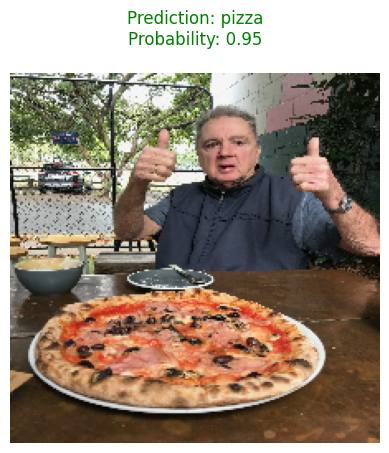

In [152]:
make_prediction('/content/03-pizza-dad.jpeg', loaded_model, class_names=class_names)